## 참고 :  https://velog.io/@vector13/Food101-데이터셋을-이용한-음식-이미지-분류기-만들기

### 1. 기본 환경 설정 

In [1]:
from shutil import copy
from collections import defaultdict
import scipy
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# Theano(th)와 Tensorflow(tf) 모두와 호환이 되는 Keras 모듈을 작성
import keras.backend as K
from keras import regularizers
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator # 데이터 전처리
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.10.0



### 2. food101 다운 소스 : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* 주의 : food101 데이터 다운받은 후 train/test 나눌 때 한번만 코드 실행

In [116]:
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
    #print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
        copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!",classes_images.keys())


# 본인 환경에 맞게 food101 들어있는 디렉토리 설정하기
prepare_data('C:/Users/Kyungseon/snu_dl/food-101/meta/train.txt', 'C:/Users/Kyungseon/snu_dl/food-101/images', 'C:/Users/Kyungseon/snu_dl/food-101/train')
prepare_data('C:/Users/Kyungseon/snu_dl/food-101/meta/test.txt', 'C:/Users/Kyungseon/snu_dl/food-101/images', 'C:/Users/Kyungseon/snu_dl/food-101/test')
   

Copying Done! dict_keys(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese

### 3. food101 데이터 기본 세팅 (전처리)

In [117]:
# releases the global state: avoid clutter from old models and layers
K.clear_session()

In [118]:
# 초기 변수 설정
n_classes = 101

### 이미지 크기 설정
img_width, img_height = 256,256


train_data_dir = 'C:/Users/Kyungseon/snu_dl/food-101/train'
validation_data_dir = 'C:/Users/Kyungseon/snu_dl/food-101/test'
nb_train_samples = 75750       # 750 * 101
nb_validation_samples = 25250  # 250 * 101
batch_size = 20                # 한 번 실행될 때 생성할 이미지 수

In [119]:
# ImageDataGenerator 객체 생성 (이미지 파일들을 Numpy Array 형태로 가져온 후 증강 기법 적용 준비)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,       # multiply the data by the value
    shear_range=0.2,        # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,         # Range for random zoom. If a float
    horizontal_flip=True)   # Randomly flip inputs horizontally

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [120]:
# flow_from_directory : meta data가 담긴 디렉토리 설정
# meta data : 이미지 데이터 파일들과 해당 이미지들이 무슨 이미지를 나타내는지 텍스트로 표현한 문자열
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


### dataset 사진 확인

(256, 256, 3) 1
(256, 256, 3) 2
(256, 256, 3) 3
(256, 256, 3) 4
(256, 256, 3) 5
(256, 256, 3) 6


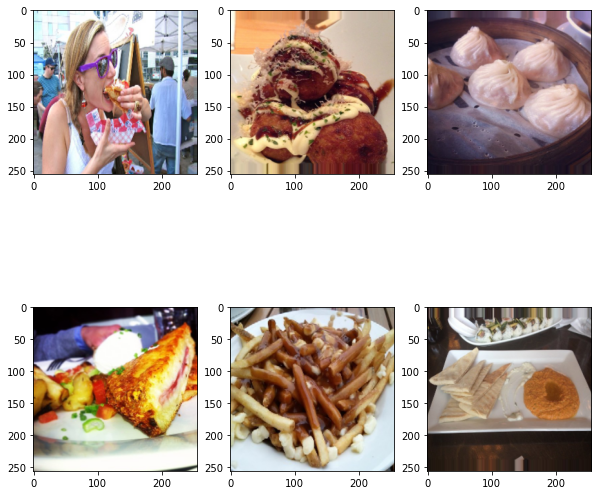

In [121]:
fig=plt.figure(figsize=(10,10))
i=0
for _ in range(6):
    i+=1
    ax=fig.add_subplot(230+i)
    img, label = train_generator.next()
    print(img[1].shape, i)  
    ax.imshow(img[1])

plt.show()

### Data augmentation
- 이미지 반전하는 함수와 이미지로 표현.
- [참고한 블로그](https://wiserloner.tistory.com/1049)

In [122]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)



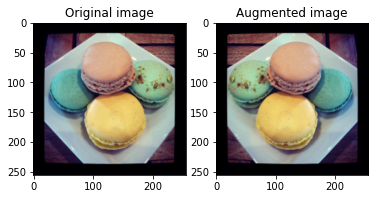

In [123]:
image, label = train_generator[0]
image=image[0]
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

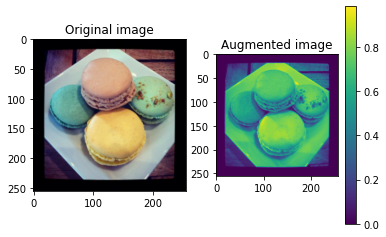

In [124]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

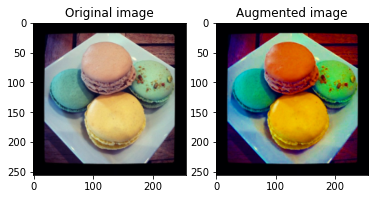

In [125]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


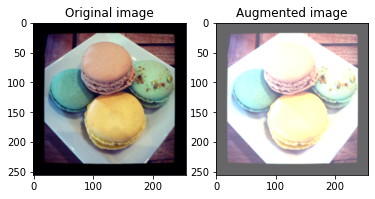

In [126]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

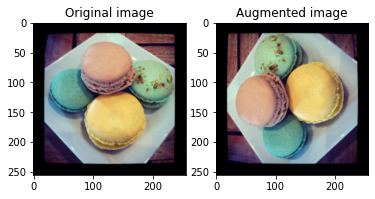

In [127]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

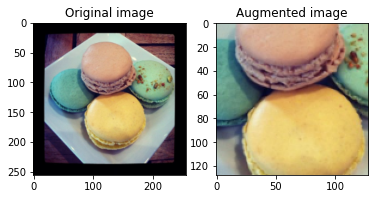

In [128]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

In [129]:
'''

dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

'''

"\n\ndataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)\ntrain_dataset, test_dataset = dataset['train'], dataset['test']\n\nnum_train_examples= info.splits['train'].num_examples\n\n"

In [130]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label

def augment(image,label):
    image,label = convert(image, label)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image,label

In [ ]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [ ]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [ ]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [ ]:
def make_model():
    '''
    model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  '''
    model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [3]:
import copy
import re
from typing import Optional, Any

from absl import logging
import tensorflow as tf

from deeplab2.model.layers.moat_blocks import MBConvBlock
from deeplab2.model.layers.moat_blocks import MOATBlock
from deeplab2.utils.hparam_configs import Config
from deeplab2.utils.hparam_configs import create_config_from_dict


ModuleNotFoundError: No module named 'deeplab2'

In [ ]:
from deeplab2.model.pixel_encoder import moat
import tensorflow as tf
import numpy as np


In [ ]:
?moat

In [2]:
ourmodel=moat.get_model(
    name='tiny_moat0_pretrain_256_no_pe_1k',input_shape=[256,256,3])

NameError: name 'moat' is not defined

In [ ]:
ourmodel.summary()

In [ ]:
hidden_2 = ourmodel.layers[2]
hidden_2.get_weights()[0:2]

In [ ]:
ourmodel = moat._load_moat_pretrained_checkpoint(ourmodel, path="./model-ckpt-0")
hidden_2 = ourmodel.layers[2]
#hidden_2.get_weights()

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

In [ ]:
ourmodel.input_shape

In [ ]:
ourmodel.output_shape

In [ ]:
#아웃풋이 텐서 10개... 개빡친다 -> 커스텀 레이어를 정의해야함...
#잘 모르니까 가내수공업으로

In [ ]:
###functional API로! 
### 아웃풋 출력 확인
### 확인할거 -> 웨이트 저장법이랑 저장 잘 되는지.

In [ ]:
y11 = tf.keras.layers.Flatten(name='flatten_layer11')(ourmodel.output["stage1"])
y12 = tf.keras.layers.Flatten(name='flatten_layer12')(ourmodel.output["res1"])
y21 = tf.keras.layers.Flatten(name='flatten_layer21')(ourmodel.output["stage2"])
y22 = tf.keras.layers.Flatten(name='flatten_layer22')(ourmodel.output["res2"])
y31 = tf.keras.layers.Flatten(name='flatten_layer31')(ourmodel.output["stage3"])
y32 = tf.keras.layers.Flatten(name='flatten_layer32')(ourmodel.output["res3"])
y41 = tf.keras.layers.Flatten(name='flatten_layer41')(ourmodel.output["stage4"])
y42 = tf.keras.layers.Flatten(name='flatten_layer42')(ourmodel.output["res4"])
y51 = tf.keras.layers.Flatten(name='flatten_layer51')(ourmodel.output["stage5"])
y52 = tf.keras.layers.Flatten(name='flatten_layer52')(ourmodel.output["res5"])

In [ ]:
z1 = y11+y12
z2 = y21+y22
z3 = y31+y32
z4 = y41+y42
z5 = y51+y52
v =tf.concat([y1,z2,z3,z4,z5],axis=1)
output_layer = tf.keras.layers.Dense(
    units=101, activation='softmax', name='output_layer')(v)





In [ ]:
model = tf.keras.models.Model(ourmodel.input, output_layer)
model.summary()

In [ ]:
### 단순히 그냥 5개의 결과+스킵커넥션을 flatten해서 FC 층 만들었더니
### 파라미터 수가 정신나감
### 구글에서 어떻게 만들었는지 보고싶은데 못보네
### 배경지식이 없어서...
### Convolution 등등의 층 붙여서 파라미터 수 줄여야될듯

### Output layer 후보
- {'stage1': (None, 128, 128, 32), 
- 'res1': (None, 128, 128, 32),
- 'stage2': (None, 64, 64, 32),
- 'res2': (None, 64, 64, 32),
- 'stage3': (None, 32, 32, 64),
- 'res3': (None, 32, 32, 64),
- 'stage4': (None, 16, 16, 128),
- 'res4': (None, 16, 16, 128),
- 'stage5': (None, 8, 8, 256),
- 'res5': (None, 8, 8, 256)}

In [131]:
from tensorflow.keras.layers import (Input, Dense, concatenate, Conv2D,MaxPooling2D, Flatten)
from tensorflow import keras

In [132]:
input_a1=Input(shape=[128,128,32],name="stage1")
input_a2=Input(shape=[128,128,32],name="res1")
input_b1=Input(shape=[64,64,32],name="stage2")
input_b2=Input(shape=[64,64,32],name="res2")
input_c1=Input(shape=[32,32,64],name="stage3")
input_c2=Input(shape=[32,32,64],name="res3")
input_d1=Input(shape=[16,16,128],name="stage4")
input_d2=Input(shape=[16,16,128],name="res4")
input_e1=Input(shape=[8,8,256],name="stage5")
input_e2=Input(shape=[8,8,256],name="res5")
'''
hidden_a1=Conv2D(2,(3,3),activation='relu')(inputa) # 126 126 64
hidden_a2=MaxPooling2D(4,4)(hidden_a1) # 34 34 64

hidden_a3=Conv2D(2,(3,3),activation='relu')(hidden_a2) # 29 29 128
hidden_a4=MaxPooling2D(4,4)(hidden_a3) # 7 7 128

hidden_a5=onv2D(2,(3,3),activation='relu')(hidden_a4) # 5 5 256
hidden_a6=MaxPooling2D(4,4)(hidden_a5) # 1 1 256
'''
hidden_a11=Conv2D(2,(3,3),activation='relu')(input_a1) # 126 126 256
hidden_a12=MaxPooling2D(126,126)(hidden_a11) # 1 1 256
f1=Flatten()(hidden_a12)

hidden_a21=Conv2D(2,(3,3),activation='relu')(input_a2) # 126 126 256
hidden_a22=MaxPooling2D(126,126)(hidden_a21) # 1 1 256
f2=Flatten()(hidden_a22)

hidden_b11=Conv2D(2,(3,3),activation='relu')(input_b1) # 62 62 256
hidden_b12=MaxPooling2D(62,62)(hidden_b11) # 1 1 256
f3=Flatten()(hidden_b12)

hidden_b21=Conv2D(2,(3,3),activation='relu')(input_b2) # 62 62 256
hidden_b22=MaxPooling2D(62,62)(hidden_b21) # 1 1 256
f4=Flatten()(hidden_b22)

hidden_c11=Conv2D(8,(3,3),activation='relu')(input_c1) # 30 30 256
hidden_c12=MaxPooling2D(30,30)(hidden_c11) # 1 1 256
f5=Flatten()(hidden_c12)

hidden_c21=Conv2D(8,(3,3),activation='relu')(input_c2) # 30 30 256
hidden_c22=MaxPooling2D(30,30)(hidden_c21) # 1 1 256
f6=Flatten()(hidden_c22)

hidden_d11=Conv2D(8,(3,3),activation='relu')(input_d1) # 30 30 256
hidden_d12=MaxPooling2D(14,14)(hidden_d11) # 1 1 256
f7=Flatten()(hidden_d12)

hidden_d21=Conv2D(8,(3,3),activation='relu')(input_d2) # 30 30 256
hidden_d22=MaxPooling2D(14,14)(hidden_d21) # 1 1 256
f8=Flatten()(hidden_d22)

hidden_e11=Conv2D(8,(3,3),activation='relu')(input_e1) # 30 30 256
hidden_e12=MaxPooling2D(6,6)(hidden_e11) # 1 1 256
f9=Flatten()(hidden_e12)

hidden_e21=Conv2D(8,(3,3),activation='relu')(input_e2) # 30 30 256
hidden_e22=MaxPooling2D(6,6)(hidden_e21) # 1 1 256
f10=Flatten()(hidden_e22)


'''
hidden1=Dense(30,activation="relu",name="hidden1")(inputa)
hidden2=Dense(30,activation="relu",name="hidden2")(hidden1)
'''
#concat=concatenate([hidden_a12,hidden_a22,hidden_b12,hidden_b22,hidden_c12,hidden_c22,hidden_d12,hidden_d22,hidden_e12,hidden_e22],name="concat")

concat=concatenate([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10], name="concat")
dense1=Dense(256,name="main_output1")(concat)
dense2=Dense(64,name="main_output2")(dense1)
dense3=Dense(1,name="main_output3")(dense2)

model=keras.Model(inputs=[input_a1,input_a2,input_b1,input_b2,input_c1,input_c2,input_d1,input_d2,input_e1,input_e2],outputs=[dense3])

model.summary()

# 각 input별 output 수가 같아야하는데 다르게 나와서 이거좀 고치는게 좋을듯.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stage1 (InputLayer)            [(None, 128, 128, 3  0           []                               
                                2)]                                                               
                                                                                                  
 res1 (InputLayer)              [(None, 128, 128, 3  0           []                               
                                2)]                                                               
                                                                                                  
 stage2 (InputLayer)            [(None, 64, 64, 32)  0           []                               
                                ]                                                             

In [133]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.compile(optimizer=SGD(learning_rate = 0.0001, momentum = 0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [134]:
checkpointer = ModelCheckpoint(filepath='best_model_3class_sept.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,      #  한 epoch에 사용한 스텝 수
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,  # 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수
                    epochs=10,                                             # 전체 훈련 데이터셋에 대해 학습 반복 횟수
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained.h5')

C:\Users\Kyungseon\AppData\Local\Temp\ipykernel_8944\246699345.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10


ValueError: in user code:

    File "C:\Users\Kyungseon\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Kyungseon\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Kyungseon\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Kyungseon\anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Kyungseon\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Kyungseon\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model" expects 10 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


In [ ]:
#creating a list of all the foods, in the argument i put the path to the folder that has all folders for food
def create_foodlist(path):
    list_ = list()
    for root, dirs, files in os.walk(path, topdown=False):
      for name in dirs:
        list_.append(name)
    return list_    

#loading the model i trained and finetuned        
my_model = load_model('model_trained.h5', compile = False)
food_list = create_foodlist("food101/images")

#function to help in predicting classes of new images loaded from my computer(for now) 
def predict_class(model, images, show = True):
  for img in images:
    img = utils.load_img(img, grayscale=False, color_mode='rgb', target_size=(299, 299))

    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)    #Returns the indices of the maximum values along an axis, In case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence are returned.
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

#add the images you want to predict into a list (these are in the WD)
images = []
images.append('sc.jpg')
images.append('vb.jpg')
images.append('vp.jpg')
images.append('es.jpg')


print("PREDICTIONS BASED ON PICTURES UPLOADED")
predict_class(my_model, images, True)

In [ ]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)